<i><span style="color:#e74c3c;"> Main Goal: </span> Predict <b>the close price</b> of a Tesla stock price using the Online Learning method with a Linear Regression model.</i>

First of all, I am very keen on trying new methods. This is why I tried an Online/Incremental Learning [1] method in this project for time series forecasting. 
In this method, our model learns from one sample of each training loop. Actually, this type of learning is very handy in the streaming data.


* I used **River** library for online/incremental learning [2],
* I created cyclical features at the feature engineering stage (1 row = 1 day, 5 rows = 1 week, 20 rows = 1 month),
* I have considered 5 rows of data as one week for cyclical features (stock price data is available only weekdays).
* I used a Linear Regression model for time series forecasting (from River),



## Proposed Pipeline
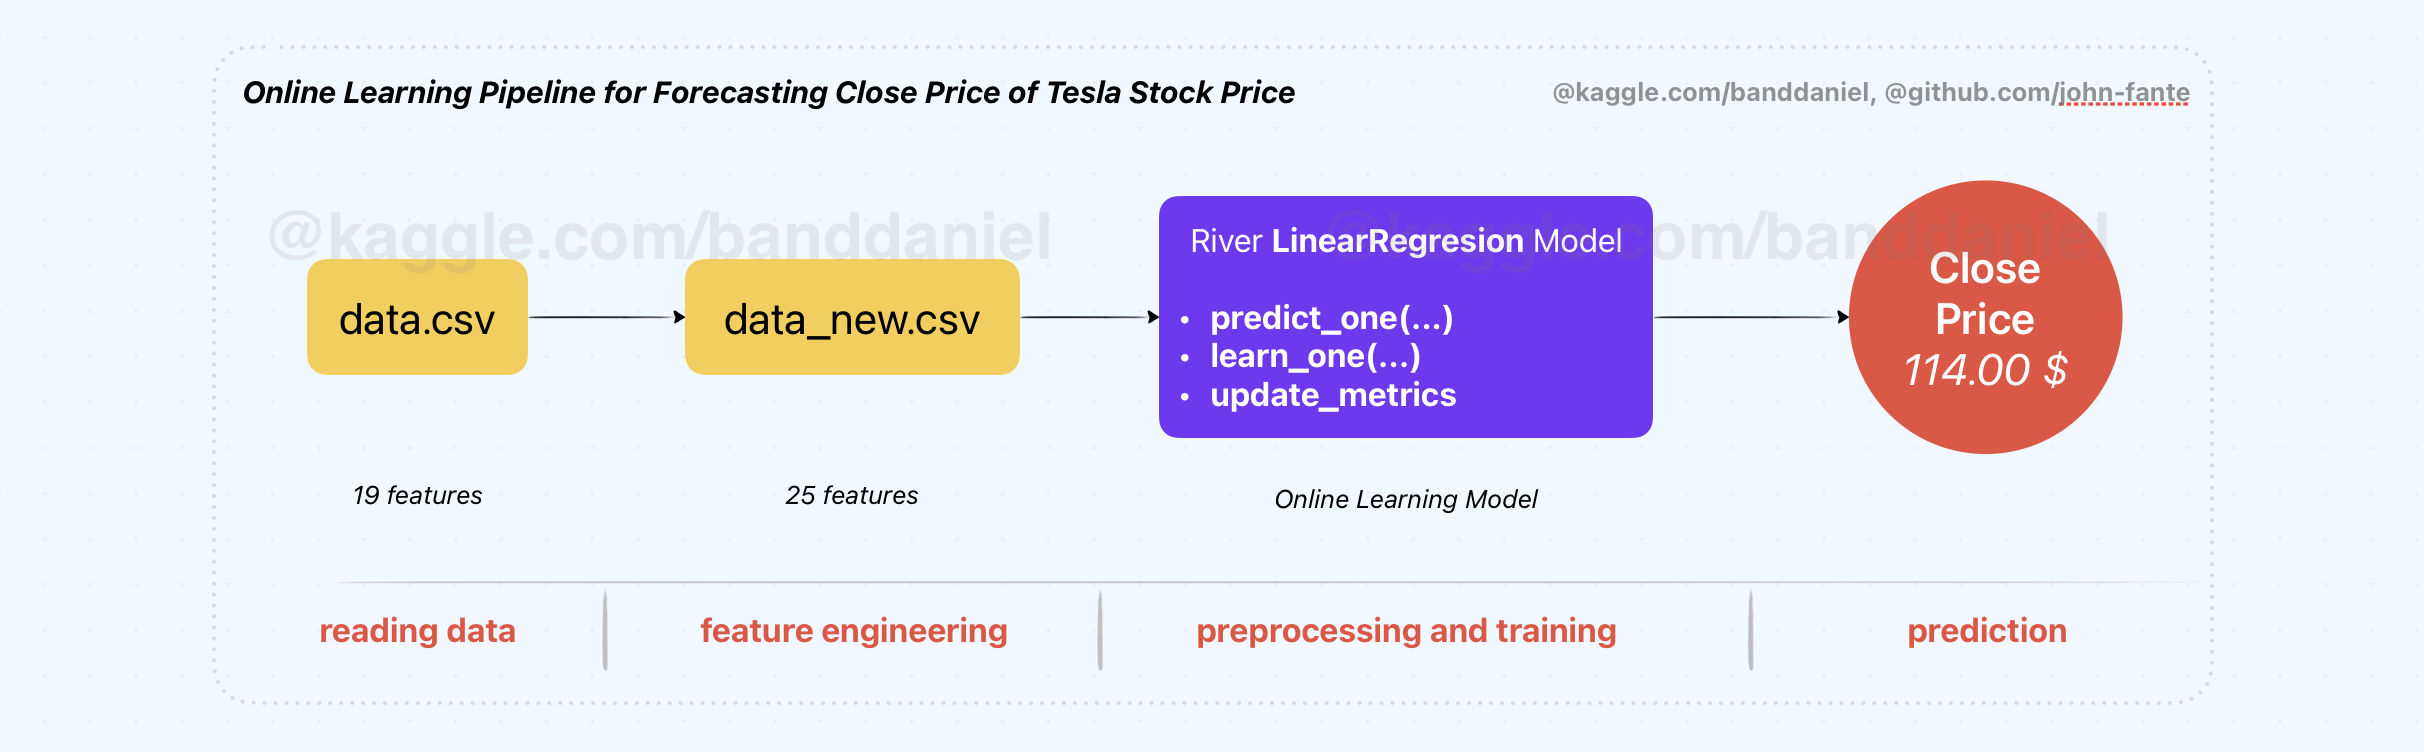


## My Another Projects
* [Towards Data Science Articles Topic Modeling w/LDA](https://www.kaggle.com/code/banddaniel/towards-data-science-articles-topic-modeling-w-lda)
* [Smoking Detection w/Online Learning (River)](https://www.kaggle.com/code/banddaniel/smoking-detection-w-online-learning-river)
* [Bladder Tissue Classification w/ViT (F1 Scr: 0.82)](https://www.kaggle.com/code/banddaniel/bladder-tissue-classification-w-vit-f1-scr-0-82)


## References
1. https://en.wikipedia.org/wiki/Incremental_learning
2. https://riverml.xyz/dev/

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import plotly.express as px

In [2]:
from IPython.display import clear_output

!pip install river==0.21.0
!pip install pytest
!pip install scipy==1.11.2

clear_output()

In [3]:
from river import compose, optim, metrics, preprocessing
from river.stream import iter_pandas
from river.linear_model import LinearRegression
from river.utils import Rolling

# <span style="color:#e74c3c;"> Feature  </span> Engineering

In [4]:
# a function for creating time series features

def create_new_features(df):
    df = df.copy()
    df['week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    # creating cycles features
    df['week_sin'] = np.sin(df['week']*(2.*np.pi/7))
    df['week_cos'] = np.sin(df['week']*(2.*np.pi/7))

    df['month_sin'] = np.sin(df['month']*(2.*np.pi/12))
    df['month_cos'] = np.sin(df['month']*(2.*np.pi/12))

    df['quarter_sin'] = np.sin(df['quarter']*(2.*np.pi/4))
    df['quarter_cos'] = np.sin(df['quarter']*(2.*np.pi/4))

    df.drop(['week', 'month' ,'quarter'], axis = 1, inplace = True)

    return df

In [5]:
# reading raw data
main_file_path = '/kaggle/input/tesla-stock-price-with-indicators-10-years/tsla_2014_2023.csv'
data = pd.read_csv(main_file_path)
data.index = pd.to_datetime(data['date'])
data.head(3)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
date,,,,,,,,,,,,,,,,,,,,
2014-01-02,2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000,55.344071,54.440118,-37.373644,15.213422,9.682107,9.820167,10.494240,9.674284,0.169472,9.740800,0.395333,0.402641,0.447550,9.970667
2014-01-03,2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000,53.742629,53.821521,-81.304471,17.481130,9.652800,9.826069,10.495693,9.680190,0.162623,9.776167,0.239333,0.379311,0.432677,9.800000
2014-01-06,2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500,46.328174,50.870410,-123.427544,-37.824708,9.629467,9.825047,10.496740,9.682577,0.141790,9.797900,0.344000,0.374267,0.426343,9.957333


In [6]:
# after feature engineering
data_new = create_new_features(data)
data_new.head(3)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,...,TrueRange,atr_7,atr_14,next_day_close,week_sin,week_cos,month_sin,month_cos,quarter_sin,quarter_cos
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000,55.344071,54.440118,-37.373644,15.213422,...,0.395333,0.402641,0.447550,9.970667,0.433884,0.433884,0.5,0.5,1.0,1.0
2014-01-03,2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000,53.742629,53.821521,-81.304471,17.481130,...,0.239333,0.379311,0.432677,9.800000,-0.433884,-0.433884,0.5,0.5,1.0,1.0
2014-01-06,2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500,46.328174,50.870410,-123.427544,-37.824708,...,0.344000,0.374267,0.426343,9.957333,0.000000,0.000000,0.5,0.5,1.0,1.0


# <span style="color:#e74c3c;"> Online Learning  </span> Pipeline

In [7]:
# csv_path -> raw data path
# window_size -> rolling parameter for updating metrics

def create_online_learning_pipeline(csv_path, window_size = 1):
    
    # reading csv file
    data = pd.read_csv(csv_path)
    data.index = pd.to_datetime(data['date'])
    
    # creating time features
    data_new = create_new_features(data)[2:]
    
    # creating stream dataset
    y = data_new.pop('close')
    X_y_stream_dataset = iter_pandas(data_new, y)
    
    
    # --------------------  ONLINE/INCREMENTAL LEARNING MODEL  --------------------

    # creatin Online/Incremental model with the River library
    model = compose.Select('volume', 'open', 'high', 'low', 'week_sin','week_cos','month_sin','month_cos','quarter_sin','quarter_cos',
                          'rsi_7','rsi_14','cci_7', 'cci_14', 'sma_50', 'ema_50','sma_100', 'ema_100','macd','bollinger', 'TrueRange','atr_7', 'atr_14',)
    
    
    model |= preprocessing.MinMaxScaler()
    model |= LinearRegression(intercept_lr = 0.1, optimizer=optim.SGD(0.03))
    model
    
    
    # --------------------  TRAINING  --------------------
    # train metrics
    mae_metric = Rolling(metrics.MAE() , window_size = window_size)
    rmse_metric = Rolling(metrics.RMSE() , window_size = window_size)

    dates = data_new.index
    y_trues = []
    y_preds = []
    
    
    # training loop
    for x, y in X_y_stream_dataset:

        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mae_metric.update(y, y_pred)
        rmse_metric.update(y, y_pred)
    
        y_trues.append(y)
        y_preds.append(y_pred)
        
        
    # final dataframe with predictions
    final_df = pd.DataFrame({'time': data_new.index,'true': y_trues, 'prediction': y_preds}, index = data_new.index)
    print(str(mae_metric) + ' , ' + str(rmse_metric))
    return final_df, mae_metric, rmse_metric



# a function for plotting predictions and ground truths
# data -> data frame
# plot_title -> title of the graph
def plot_predictions(data, plot_title):
    fig = px.line(data, x='time', y=['prediction','true'])
    
    fig.update_layout(xaxis_range=['2023-01-01','2023-12-29'], title_text= plot_title +" - after January 2023")
    
    fig.update_xaxes(rangeslider_visible=True)
    fig.show()

# <span style="color:#e74c3c;"> (Using 1 Day Data) </span> Training and Prediction

In [8]:
# training
win1_preds, win1_mae, win1_rmse = create_online_learning_pipeline(main_file_path, window_size = 1)

# predictions plot
plot_predictions(win1_preds, 'the window size is 1 (daily)')

MAE: 9.526232 , RMSE: 9.526232


# <span style="color:#e74c3c;"> (Using 5 Days Data) </span> Training and Prediction

In [9]:
# training
win5_preds, win5_mae, win5_rmse = create_online_learning_pipeline(main_file_path, window_size = 5)

# predictions plot
plot_predictions(win5_preds, 'the window size is 5 (weekly)')

MAE: 3.510661 , RMSE: 4.863219


# <span style="color:#e74c3c;"> (Using 20 Days Data) </span> Training and Prediction

In [10]:
# training
win20_preds, win20_mae, win20_rmse = create_online_learning_pipeline(main_file_path, window_size = 20)

# predictions plot
plot_predictions(win20_preds, 'the window size is 20 (mothly)')

MAE: 4.963705 , RMSE: 6.551216


# <span style="color:#e74c3c;"> Results </span>

In [11]:
print('1 window size results \t',win1_mae, win1_rmse)
print('5 window size results \t',win5_mae, win5_rmse)
print('20 window size results \t',win20_mae, win20_rmse)

1 window size results 	 MAE: 9.526232 RMSE: 9.526232
5 window size results 	 MAE: 3.510661 RMSE: 4.863219
20 window size results 	 MAE: 4.963705 RMSE: 6.551216
